## This file explores relationship between power demand and temperature, deseasonalizes power demand and builds multiple regressors for power demand using temperature

In [49]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

import holidays
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import tqdm as notebook_tqdm

In [2]:
dmd_temp_df = pd.read_csv('../data/cleaned_temp_dmnd_2017_2022.csv')

In [3]:
dmd_temp_df.shape

(8764, 4)

In [4]:
# convert observation_dtg_utc column to datetime format
dmd_temp_df['observation_dtg_utc'] = pd.to_datetime(dmd_temp_df['observation_dtg_utc'])

# set observation_dtg_utc column as the index
dmd_temp_df.set_index('observation_dtg_utc', inplace=True)

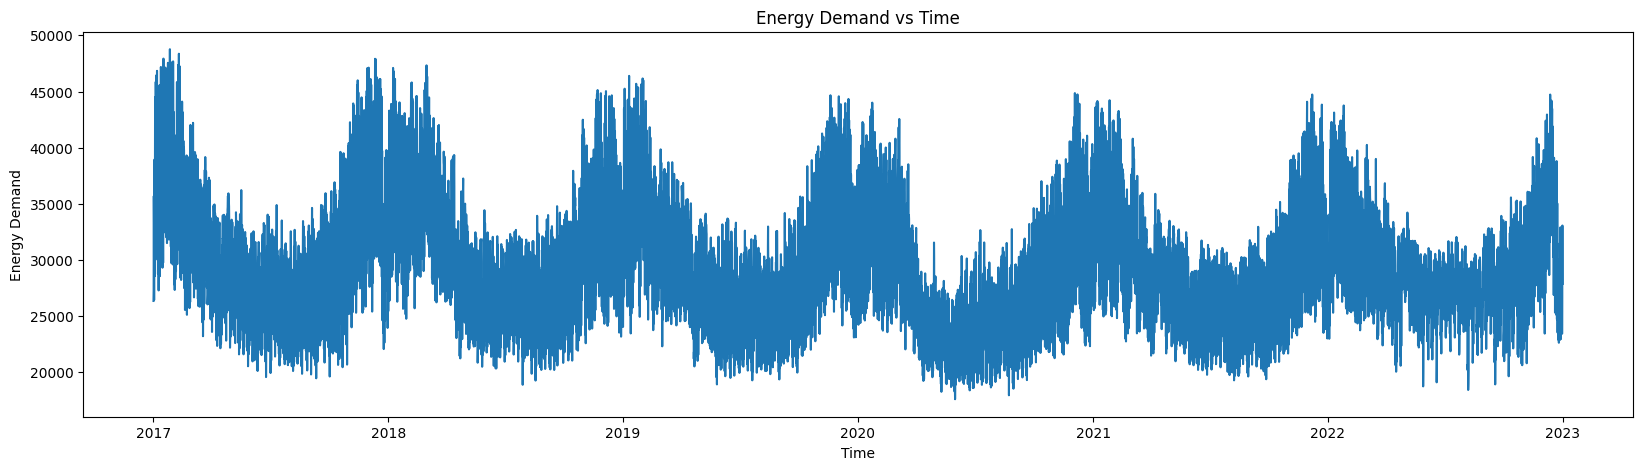

In [5]:
# create a plot
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(dmd_temp_df.index, dmd_temp_df['TSD'])
ax.set(xlabel='Time', ylabel='Energy Demand', title='Energy Demand vs Time')
plt.show()

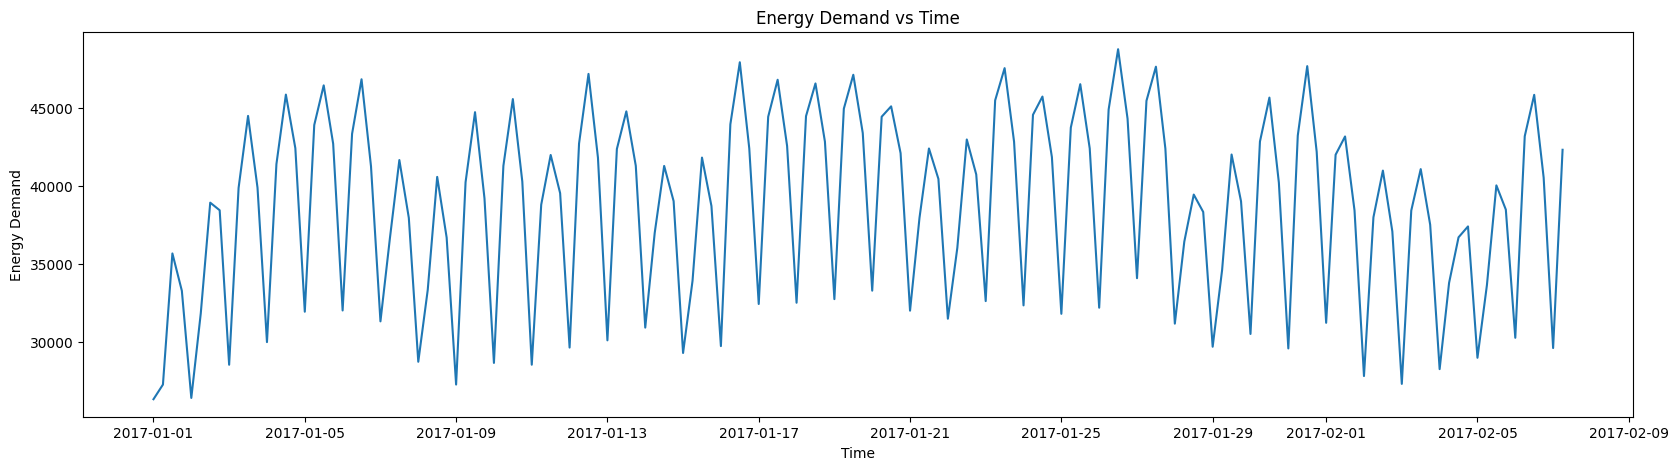

In [6]:
# create a plot
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(dmd_temp_df[:150].index, dmd_temp_df[:150]['TSD'])
ax.set(xlabel='Time', ylabel='Energy Demand', title='Energy Demand vs Time')
plt.show()

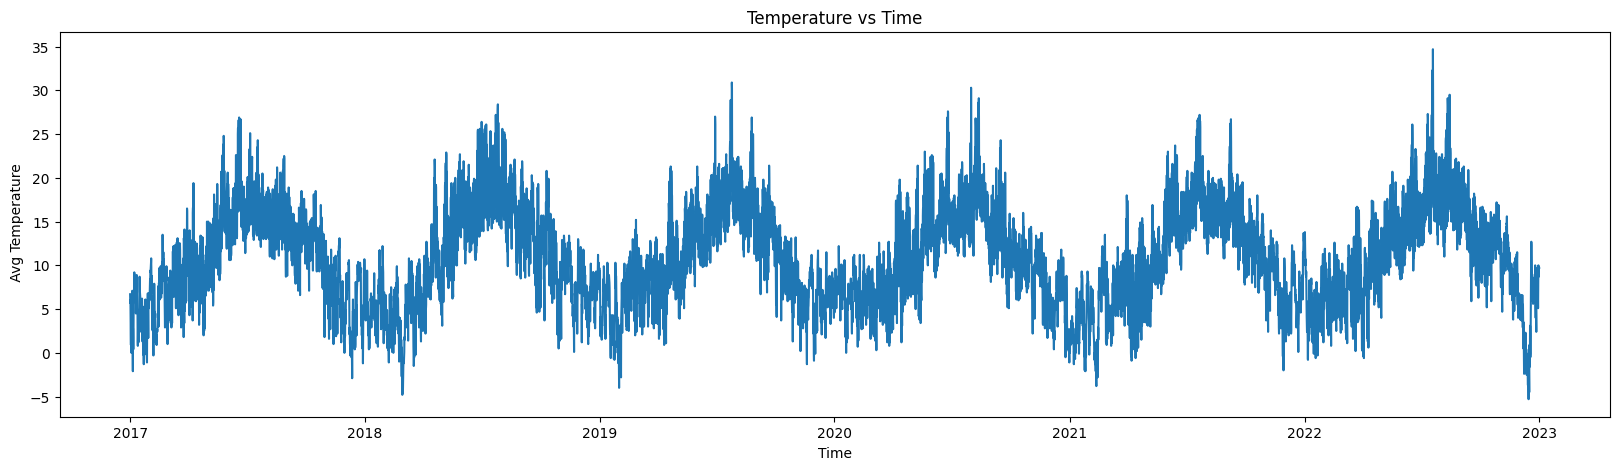

In [7]:
# create a plot
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(dmd_temp_df.index, dmd_temp_df['temp_c'])
ax.set(xlabel='Time', ylabel=' Avg Temperature', title='Temperature vs Time')
plt.show()

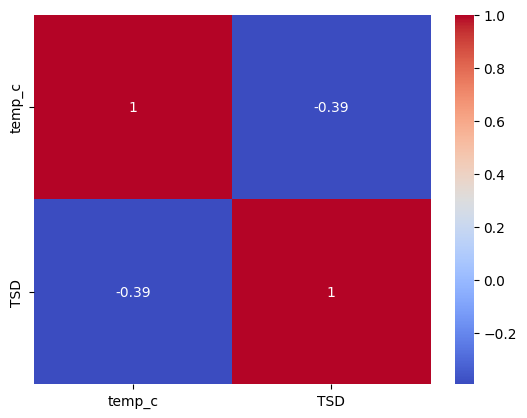

In [8]:
# Calculate the correlation matrix
corr_matrix = dmd_temp_df[['temp_c', 'TSD']].corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Show the plot
plt.show()

## Checking stationarity of data

### Statistical Testing

In [9]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [10]:
#apply adf test on the series
adf_test(dmd_temp_df['TSD'])

Results of Dickey-Fuller Test:
Test Statistic                   -4.944749
p-value                           0.000029
#Lags Used                       37.000000
Number of Observations Used    8726.000000
Critical Value (1%)              -3.431100
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64


If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary).
In our above example, the test statistic < critical value, which implies that the series is stationary. 

## Removing daily seasonailty by taking avg of all days. 

In [11]:
dmd_temp_df_dailygrp = dmd_temp_df.copy()

In [12]:
dmd_temp_df_dailygrp = dmd_temp_df_dailygrp.groupby('SETTLEMENT_DATE').resample('D').mean()

In [13]:
dmd_temp_df_dailygrp = dmd_temp_df_dailygrp.sort_values(by = 'observation_dtg_utc')

In [14]:
dmd_temp_df_dailygrp = dmd_temp_df_dailygrp.reset_index()

In [15]:
df = dmd_temp_df_dailygrp.drop('SETTLEMENT_DATE', axis = 1).copy()

In [16]:
df = df.rename(columns={'observation_dtg_utc':'Date', 'temp_c':'Temperature'})

### Plots after condensing the data to one reading per day.

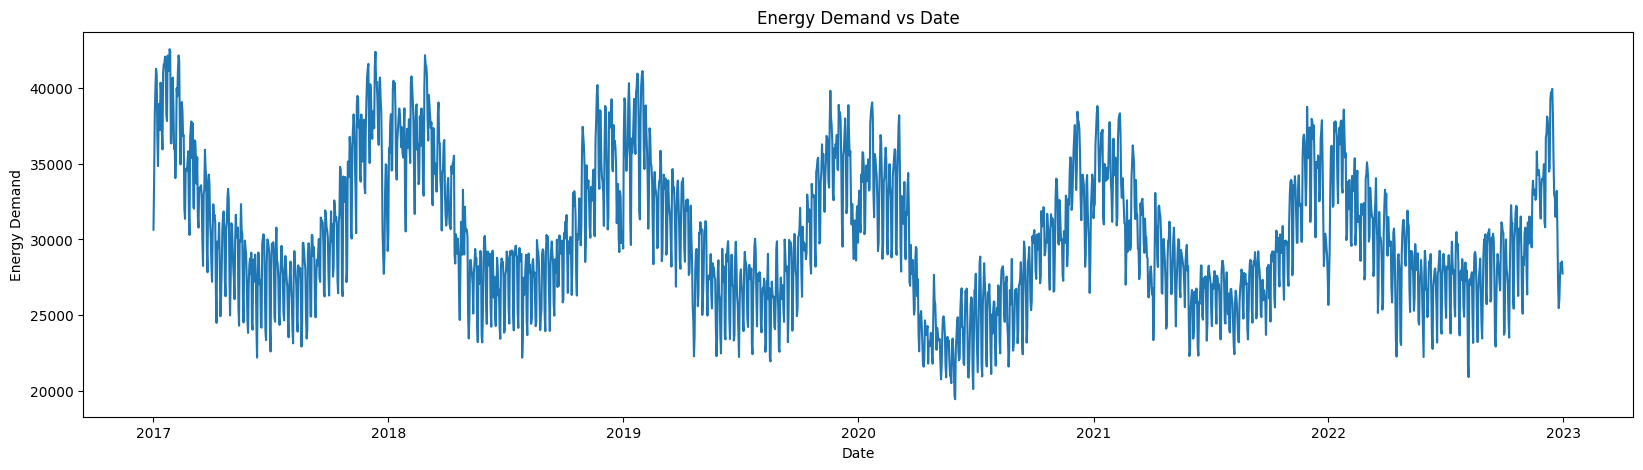

In [17]:
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(df['Date'], df['TSD'])
ax.set(xlabel='Date', ylabel='Energy Demand', title='Energy Demand vs Date')
plt.show()

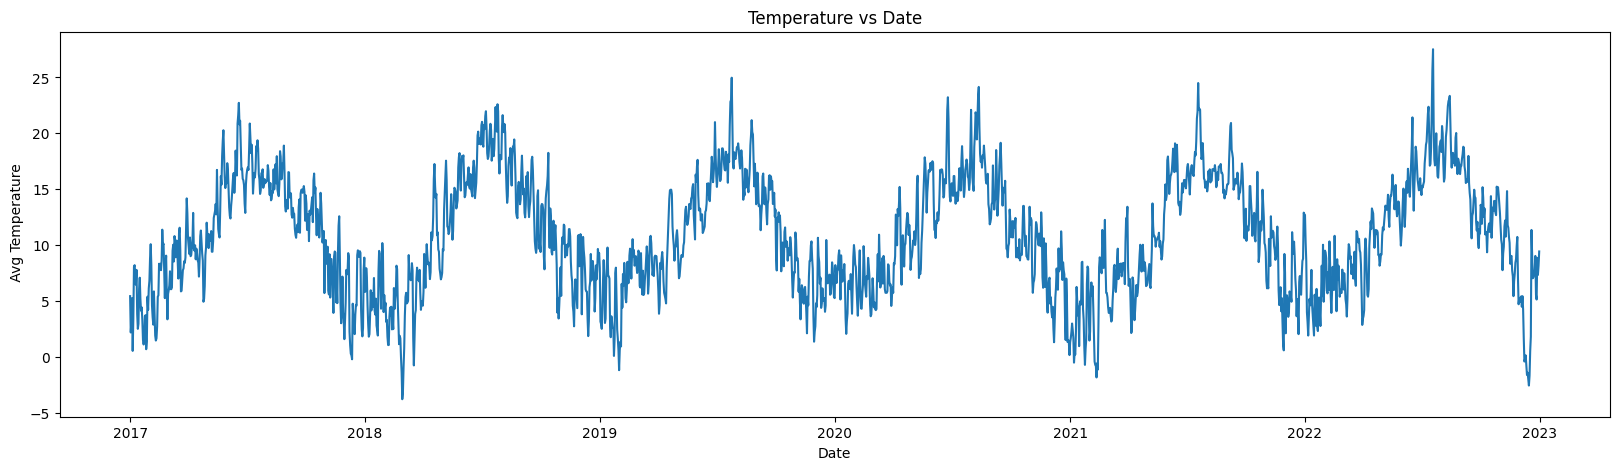

In [18]:
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(df['Date'], df['Temperature'])
ax.set(xlabel='Date', ylabel=' Avg Temperature', title='Temperature vs Date')
plt.show()

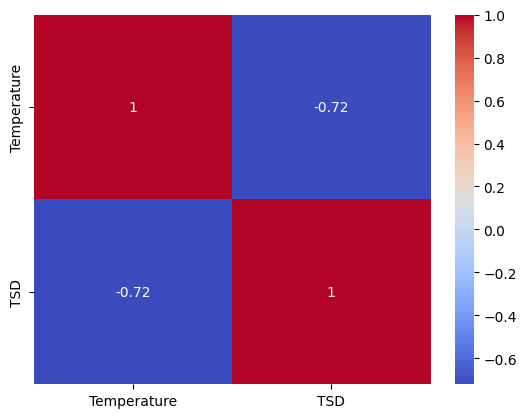

In [19]:
# Calculate the correlation matrix
corr_matrix = df[['Temperature', 'TSD']].corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Show the plot
plt.show()

In [20]:
df = df.set_index('Date')

## Choosing best way to handle seasonality

#### The seasonality in demand looks additive in nature and hence we're removing using additive model

In [21]:
#seasonal decomposition plots

# Perform seasonal decomposition to capture weekly seasonality
decomposition = seasonal_decompose(df['TSD'], model = 'additive', period = 7)
trend = decomposition.trend
seasonal = decomposition.seasonal
# residual = decomposition.resid


In [22]:
df['deseasonalized_TSD'] = df['TSD'] - seasonal
df['energy_demand_trend'] = trend

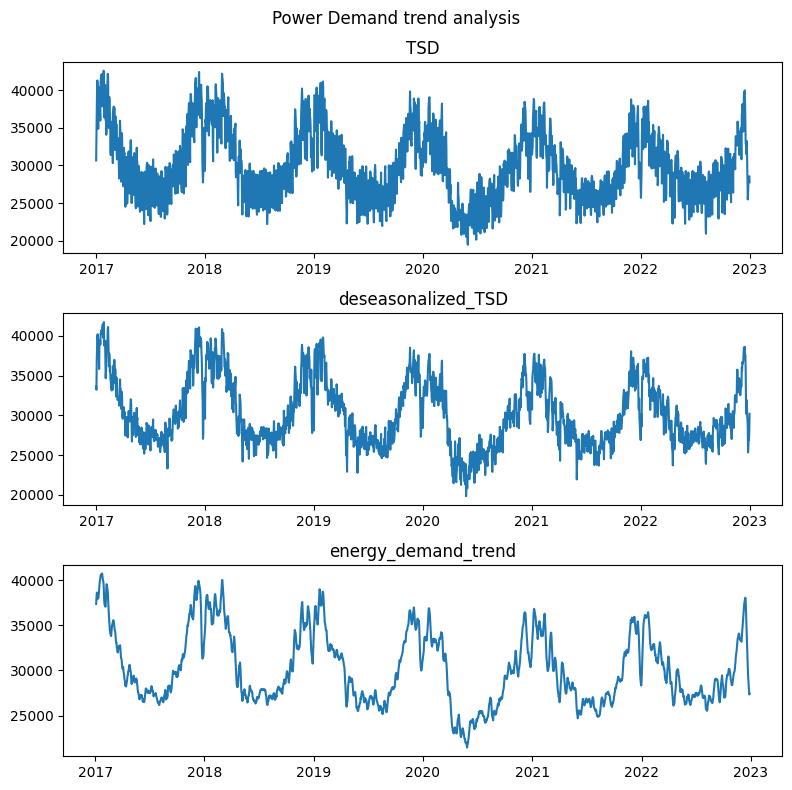

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))

# plot data on the first subplot
ax1.plot(df.index, df.TSD)
ax1.set_title('TSD')

# plot data on the second subplot
ax2.plot(df.index, df.deseasonalized_TSD)
ax2.set_title('deseasonalized_TSD')

# plot data on the third subplot
ax3.plot(df.index, df.energy_demand_trend)
ax3.set_title('energy_demand_trend')

# add overall title and adjust spacing between subplots
fig.suptitle('Power Demand trend analysis')
fig.tight_layout(pad=1.0)

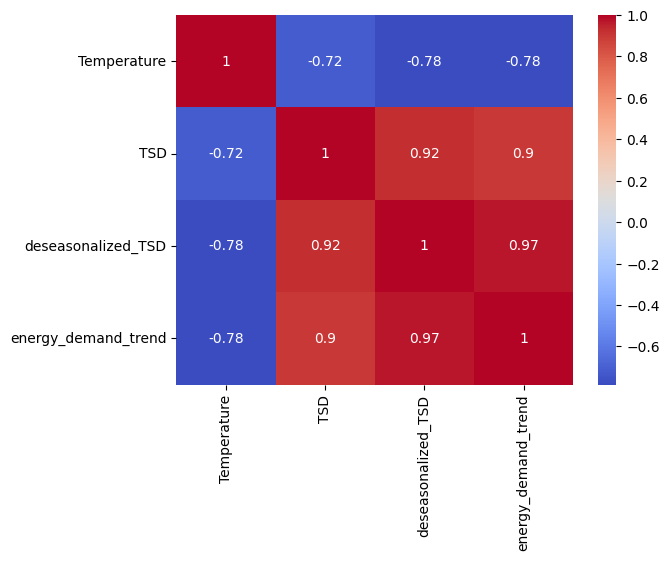

In [24]:
# Calculate the correlation matrix
corr_matrix2 = df[['Temperature', 'TSD', 'deseasonalized_TSD','energy_demand_trend']].corr()

# Plot the heatmap
sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm')

# Show the plot
plt.show()

#### It can be observed that the correlation between power demand and temperature increased when condensing the 6H data to 1 day data. Similarly it can be observed that correlation increases further between demand and deseasonilized TSD

## Removing Holidays

In [25]:
uk_holidays = holidays.GB()

In [26]:
df['is_holiday'] = df.index.map(lambda x: x in uk_holidays)

In [27]:
df['is_holiday'] = df['is_holiday'].astype(int)

## Testing different Models

### Random Forest Regressor

In [28]:
# Split data into features and target
X = df[['Temperature','is_holiday']]
y = df['deseasonalized_TSD']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Create random forest regressor model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Predict power demand using temperature
y_pred = rf.predict(X_test)

In [30]:
# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print evaluation metrics
print('R2 score:', r2)
print('RMSE:', rmse)

R2 score: 0.5239520233226609
RMSE: 2864.0754360749756


### Polynomial Regression

In [31]:
# Split data into features and target
X = df[['Temperature', 'is_holiday']]
y = df['deseasonalized_TSD']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# create polynomial features
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)

# train linear regression model with polynomial features
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)

# predict on test set
X_test_poly = poly_features.transform(X_test)
y_pred = poly_reg.predict(X_test_poly)

In [33]:
## Sample prediction
# temp_test = poly_features.transform([[20,1]])
# poly_reg.predict(temp_test)

In [34]:
# Get the coefficients and intercept
coefficients = poly_reg.coef_
intercept = poly_reg.intercept_

In [35]:
print('coefficients: ',list(coefficients), "intercept: ",intercept)

coefficients:  [0.0, -1302.83874352999, -1863.827916966782, 30.12056212988159, 127.53583989588604, -1863.827916966783] intercept:  40099.19296202576


In [36]:
poly_features.powers_

array([[0, 0],
       [1, 0],
       [0, 1],
       [2, 0],
       [1, 1],
       [0, 2]])

### The equation for power demand as a function of Temperature and Holiday flag

### y=β0 + β1​x1 + β2​x2 + β3​x1^2 + β4​x1​x2 + β5​x2^2

In [37]:
# calculate R-squared
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print evaluation metrics
print('R2 score:', r2)
print('RMSE:', rmse)

R2 score: 0.6468978545764025
RMSE: 2466.6598730233304


In [38]:
print(X_test.shape, y_test.shape)

(439, 2) (439,)


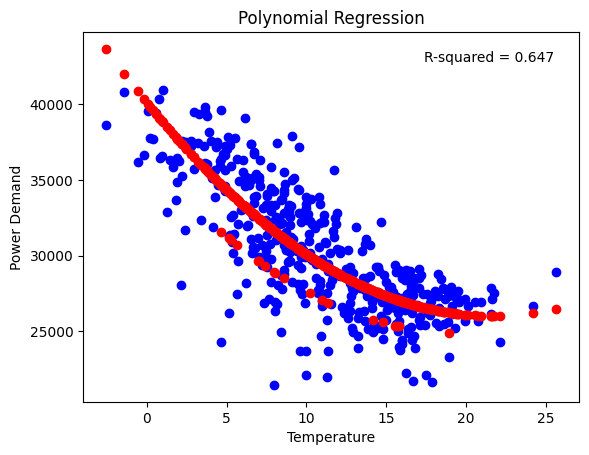

In [39]:
# plot results
plt.scatter(X_test['Temperature'], y_test, color='blue')
plt.scatter(X_test['Temperature'], y_pred, color='red')
plt.title('Polynomial Regression')
plt.xlabel('Temperature')
plt.ylabel('Power Demand')
plt.text(0.95, 0.95, 'R-squared = {:.3f}'.format(r2), transform=plt.gca().transAxes, ha='right', va='top')
plt.show()

## Prophet

In [40]:
# # Split the data into training and test sets
train_data = df.loc[:'2021-12-31'].drop(['is_holiday', 'energy_demand_trend', 'TSD'], axis=1)
test_data = df.loc['2022-01-01':].drop(['is_holiday', 'energy_demand_trend', 'TSD'], axis=1)

In [41]:
print(train_data.shape, test_data.shape)

(1826, 2) (365, 2)


In [42]:
# Prepare the data for Prophet
train_data = train_data.reset_index()
train_data = train_data.rename(columns={'Date': 'ds', 'deseasonalized_TSD': 'y', 'Temperature': 'temp'})

In [43]:
# Fit the Prophet model
model = Prophet()
model.add_country_holidays('UK')
model.add_regressor('temp')
model.fit(train_data)

21:34:48 - cmdstanpy - INFO - Chain [1] start processing
21:34:49 - cmdstanpy - INFO - Chain [1] done processing


In [44]:
# Make predictions on the test data
test_data = test_data.reset_index()
test_data = test_data.rename(columns={'Date': 'ds', 'deseasonalized_TSD': 'y', 'Temperature': 'temp'})
forecast = model.predict(test_data)

In [45]:
# mse = mean_squared_error(test_data['y'], forecast['yhat'])
rmse = mean_squared_error(test_data['y'], forecast['yhat'], squared=False)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print('R2 score:', r2)
# print("MSE:", mse)
print("RMSE:", rmse)

R2 score: 0.6468978545764025
RMSE: 1852.3218674660545


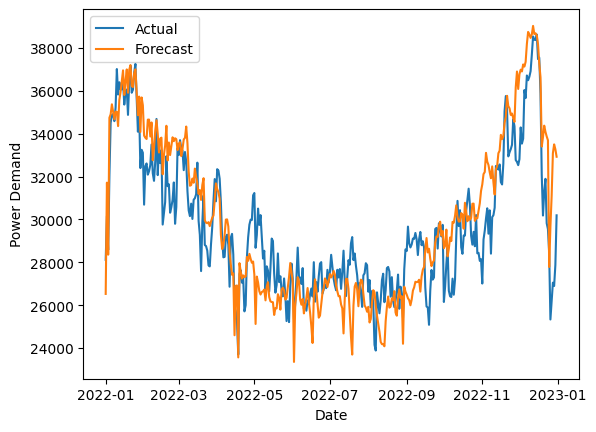

In [46]:
# Plot the forecast and actual values
fig, ax = plt.subplots()
ax.plot(test_data['ds'], test_data['y'], label='Actual')
ax.plot(forecast['ds'], forecast['yhat'], label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Power Demand')
ax.legend()
plt.show()

# END